# Post-processing for OPF test cases

In this notebook, we will show how to post-process the results of the OPF test cases. The results are stored in the `results` folder. The model runs are in 2018. 

Includes the following scenarios:

1. Base case without renewable generation, stored in `results/wo_renew`.

2. Cases with renewable generation, stored in `results/w_renew`.


## Packages

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pickle

plt.rcParams["font.family"] = "Times New Roman"


In [17]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

solar_data_dir = os.path.join(data_dir, 'solar')
print('Solar data directory: {}'.format(solar_data_dir))

onshore_wind_data_dir = os.path.join(data_dir, 'onshore_wind')
print('Onshore wind data directory: {}'.format(onshore_wind_data_dir))

offshore_wind_data_dir = os.path.join(data_dir, 'offshore_wind')
print('Offshore wind data directory: {}'.format(offshore_wind_data_dir))

Grid data directory: /home/by276/models/NYgrid-python/data/grid
Figure directory: /home/by276/models/NYgrid-python/figures
Results directory: /home/by276/models/NYgrid-python/results
Solar data directory: /home/by276/models/NYgrid-python/data/solar
Onshore wind data directory: /home/by276/models/NYgrid-python/data/onshore_wind
Offshore wind data directory: /home/by276/models/NYgrid-python/data/offshore_wind


## Read grid data

In [18]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

In [19]:
# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
load_profile.index.freq = 'H'

# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gen_profile.index.freq = 'H'


## Read OPF results

In [21]:
thermal_pg_wo_renew_list = list()
thermal_pg_w_renew_list = list()
model_wo_renew_list = list()
model_w_renew_list = list()
results_wo_renew_list = list()
results_w_renew_list = list()

# Loop through all days
for d in range(len(timestamp_list)-1):
    # Set up timestamps
    start_datetime = timestamp_list[d]
    end_datetime = start_datetime + timedelta(hours=23)

    # Read thermal generation without renewable energy
    filename = f'thermal_wo_renew_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.csv'
    thermal_pg_wo_renew = pd.read_csv(os.path.join(results_dir, 'wo_renew', filename),
                                      parse_dates=['TimeStamp'], index_col='TimeStamp')
    thermal_pg_wo_renew_list.append(thermal_pg_wo_renew)

    # Read pickle file
    # filename = f'nygrid_sim_wo_renew_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.pkl'
    # with open(os.path.join(results_dir, 'wo_renew', filename), 'rb') as f:
    #     [nygrid_sim, model_multi_opf, results] = pickle.load(f)
    # model_wo_renew_list.append(model_multi_opf)
    # results_wo_renew_list.append(results)
    
    # Read thermal generation with renewable energy
    filename = f'thermal_w_renew_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.csv'
    thermal_pg_w_renew = pd.read_csv(os.path.join(results_dir, 'w_renew', filename),
                                    parse_dates=['TimeStamp'], index_col='TimeStamp')
    thermal_pg_w_renew_list.append(thermal_pg_w_renew)

    # Read pickle file
    # filename = f'nygrid_sim_w_renew_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.pkl'
    # with open(os.path.join(results_dir, 'w_renew', filename), 'rb') as f:
    #     [nygrid_sim, model_multi_opf, results] = pickle.load(f)
    # model_w_renew_list.append(model_multi_opf)
    # results_w_renew_list.append(results)

    print(f'Finished reading file for {start_datetime}')

# Concatenate thermal generation profiles
thermal_pg_wo_renew = pd.concat(thermal_pg_wo_renew_list)
thermal_pg_w_renew = pd.concat(thermal_pg_w_renew_list)

Finished reading file for 2018-01-01 00:00:00
Finished reading file for 2018-01-02 00:00:00
Finished reading file for 2018-01-03 00:00:00
Finished reading file for 2018-01-04 00:00:00
Finished reading file for 2018-01-05 00:00:00
Finished reading file for 2018-01-06 00:00:00
Finished reading file for 2018-01-07 00:00:00
Finished reading file for 2018-01-08 00:00:00
Finished reading file for 2018-01-09 00:00:00
Finished reading file for 2018-01-10 00:00:00
Finished reading file for 2018-01-11 00:00:00
Finished reading file for 2018-01-12 00:00:00
Finished reading file for 2018-01-13 00:00:00
Finished reading file for 2018-01-14 00:00:00
Finished reading file for 2018-01-15 00:00:00
Finished reading file for 2018-01-16 00:00:00
Finished reading file for 2018-01-17 00:00:00
Finished reading file for 2018-01-18 00:00:00
Finished reading file for 2018-01-19 00:00:00
Finished reading file for 2018-01-20 00:00:00
Finished reading file for 2018-01-21 00:00:00
Finished reading file for 2018-01-

In [ ]:
# Save to csv
thermal_pg_wo_renew.to_csv(os.path.join(results_dir, 'thermal_pg_wo_renew.csv'))
thermal_pg_w_renew.to_csv(os.path.join(results_dir, 'thermal_pg_w_renew.csv'))

## Plotting

<Axes: title={'center': 'Difference in thermal generation (w/o renew - w/ renew)'}, xlabel='TimeStamp'>

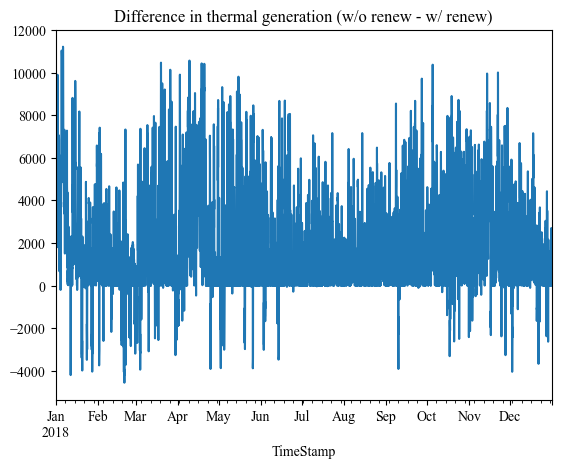

In [38]:
thermal_pg_diff = thermal_pg_wo_renew - thermal_pg_w_renew
thermal_pg_diff.sum(axis=1).plot(title='Difference in thermal generation (w/o renew - w/ renew)')

In [22]:
# Read thermal generator info table
filename = os.path.join(data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


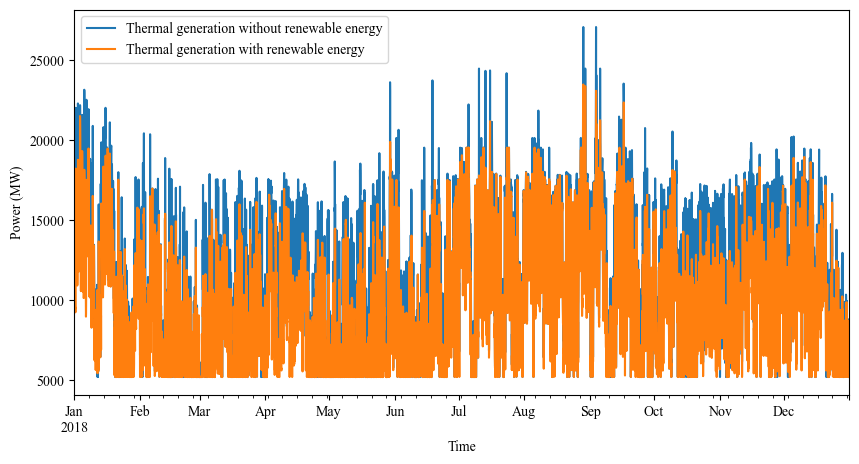

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
thermal_pg_wo_renew.sum(axis=1).plot(ax=ax, label='Thermal generation without renewable energy')
thermal_pg_w_renew.sum(axis=1).plot(ax=ax, label='Thermal generation with renewable energy')

ax.set_ylabel('Power (MW)')
ax.set_xlabel('Time')
ax.legend()
plt.show()  


In [26]:
start_datetime = datetime(2018, 1, 1, 0, 0, 0)
end_datetime = datetime(2018, 1, 7, 0, 0, 0)

NYISOName        Arthur Kill ST 3
PTID                        23513
Zone                            J
UnitType            Steam Turbine
FuelType              Natural Gas
Latitude                  40.5915
Longitude                -74.2027
maxPower                    539.0
minPower                      1.0
maxRampAgc                   53.9
maxRamp10                   539.0
maxRamp30                   539.0
maxRamp60                   539.0
HeatRateLM_1              8.88948
HeatRateLM_0           340.374965
HeatRateLM_R2            0.986235
HeatRateQM_2            -0.003565
HeatRateQM_1            10.324775
HeatRateQM_0           231.015136
HeatRateQM_R2             0.99146
useQM                           1
start-time                    10m
Name: 8, dtype: object


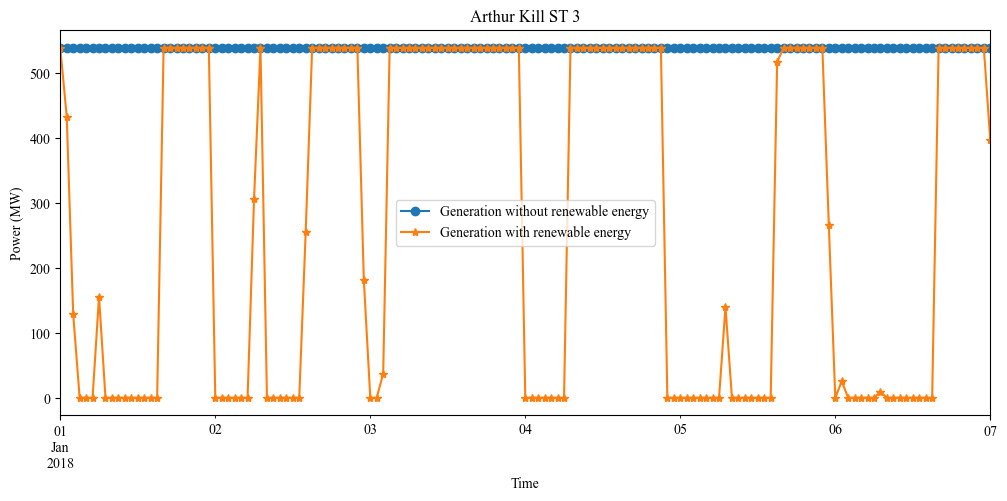

In [32]:
ii = 8

print(gen_info.iloc[ii, :])

fig, ax = plt.subplots(figsize=(12, 5))
thermal_pg_wo_renew.iloc[:, ii].plot(ax=ax, marker='o', label='Generation without renewable energy')
thermal_pg_w_renew.iloc[:, ii].plot(ax=ax, marker='*', label='Generation with renewable energy')

ax.set_xlim([start_datetime, end_datetime])

ax.set_ylabel('Power (MW)')
ax.set_xlabel('Time')
ax.set_title(gen_info.iloc[ii, :].NYISOName)
ax.legend()
plt.show()  

In [ ]:
# Read thermal generator info table
filename = os.path.join(data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
gen_info

# Plots

# Total generation

In [ ]:
total_load = load_profile.sum(axis=1)
total_load_new = load_new.sum(axis=1)
total_solar_gen = solar_gen[start_time: end_time].sum(axis=1)
total_wind_gen = wind_gen[start_time: end_time].sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(total_load.index, total_load, 
        color='black', linestyle='-', linewidth=4,
        label='Total load')
ax.plot(total_load_new.index, total_load_new,
        color='tab:green', linestyle='--', linewidth=2)

ax.fill_between(total_solar_gen.index, 0, total_load_new,
                alpha=0.7, color='lightgray',
                label='Residual load')

ax.fill_between(total_solar_gen.index, total_load_new, 
                total_load_new + total_solar_gen,
                alpha=0.7,
                label='Solar generation')
ax.fill_between(total_wind_gen.index, total_load_new + total_solar_gen, 
                total_load_new + total_solar_gen + total_wind_gen,
                alpha=0.7,
                label='Wind generation')

ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xlim(start_time, end_time)
ax.set_ylim(50000, 100000)
ax.set_xlabel('Time', fontsize=24)
ax.set_ylabel('Power (MW)', fontsize=24)
ax.tick_params(axis='both', labelsize=24)
ax.legend(fontsize=24)

fig_name = f'../figures/load_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.png'
fig.tight_layout()
fig.savefig(fig_name, dpi=300)
plt.show()

## Individual generators

In [ ]:
def plot_gen(gen_name, thermal_pg, thermal_pg_new):

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    ax.plot(thermal_pg.index, thermal_pg[gen_name], linestyle='-',
            label='Base case')
    ax.plot(thermal_pg_new.index, thermal_pg_new[gen_name], linestyle='--',
            label='With renewable')

    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    ax.set_xlim(start_time, end_time)
    # ax.set_ylim(0, 70)

    ax.set_title(gen_name, fontsize=24)
    ax.set_xlabel('Time', fontsize=24)
    ax.set_ylabel('Generation (MW)', fontsize=24)
    ax.tick_params(axis='both', labelsize=24)
    ax.legend(fontsize=24)
    fig.tight_layout()

    return fig, ax

In [ ]:
for gen_name in thermal_pg.columns:

    fig, ax = plot_gen(gen_name, thermal_pg, thermal_pg_new)
    
    fig_name = f'../figures/thermal_gen/{gen_name.replace("/", "")}_{start_time.strftime("%Y%m%d")}_{end_time.strftime("%Y%m%d")}.png'
    fig.savefig(fig_name, dpi=300)
    plt.close()
    